In [63]:
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np
import diffrax
import jax.random as jr
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax.scipy.special as jsp_special
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [49]:
import equinox as eqx
import jax.numpy as jnp
import jax.nn as jnn

class Func(eqx.Module):
    layers: list

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        keys = jax.random.split(key, depth + 1)

        self.layers = []
        # Input layer
        self.layers.append(eqx.nn.Linear(in_features=data_size, out_features=width_size, key=keys[0]))

        # Hidden layers
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(in_features=width_size, out_features=width_size, key=keys[i + 1]))

        # Output layer
        self.layers.append(eqx.nn.Linear(in_features=width_size, out_features=data_size, key=keys[depth]))

    def __call__(self, t, y, args=None):
        """
        Defines the forward pass of the model.
        
        :param t: Time input, unused in this MLP but provided for compatibility with ODE solvers.
        :param y: The input data, typically the state of the ODE.
        :param args: Additional arguments (e.g., Fourier features or other auxiliary information).
        """
        # Concatenate extra arguments if provided
        if args is not None:
            y = jnp.concatenate([y, args], axis=-1)
        
        print(f"MLP Input Shape: {y.shape}")

        # Pass through each layer with ReLU activation in between
        for layer in self.layers[:-1]:
            y = layer(y)
            y = jnn.relu(y)

        # Apply the final layer without activation
        y = self.layers[-1](y)

        return y


In [38]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, input_size, width_size, depth, *, key):
        self.func = Func(input_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        # Ensure y0 has the correct shape
        y0 = y0.reshape(-1)
        print(f"Calling ODE solver with y0 shape: {y0.shape} and ts shape: {ts.shape}")

        # Wrap the func with an ODETerm for the solver
        ode_term = diffrax.ODETerm(self.func)

        # Solve the ODE using diffrax
        solution = diffrax.diffeqsolve(
            ode_term,
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            saveat=diffrax.SaveAt(ts=ts),
            max_steps=1000
        )

        print(f"ODE solve completed: solution shape = {solution.ys.shape}")
        return solution.ys

In [3]:
# Define the model structure with the same parameters used during training
# Replace `input_size`, `width_size`, `depth`, and `key` with the values used when saving the model
data_size = 5  # For example, if your input size is 5
width_size = 32
depth = 6
key = jr.PRNGKey(0)  # Replace with the seed or key you used

# Initialize an empty model with the same structure
empty_model = NeuralODE(data_size, width_size=width_size, depth=depth, key=key)

# Now load the saved parameters into this model structure
neural_ode_model = eqx.tree_deserialise_leaves("trained_neural_ode.eqx", empty_model)

# `neural_ode_model` now contains the trained weights and biases and is ready for use.

NeuralODE initialized with manually defined layers.


In [9]:
def get_data_from_matlab(matlab_file_path, downsample_factor=10):
    print(f"Loading MATLAB data from: {matlab_file_path}")

    # Load the MATLAB file
    matlab_data = scipy.io.loadmat(matlab_file_path)
    print("MATLAB data loaded successfully.")

    # Extract time and data arrays
    ts = matlab_data['time1'].flatten()
    ys = matlab_data['dataEng1']
    # print(f"Original time shape: {ts.shape}, Original data shape: {ys.shape}")

    # Downsample time and data
    ts = ts[::downsample_factor]
    ys = ys[::downsample_factor, :]
    # print(f"Downsampled time shape: {ts.shape}, Downsampled data shape: {ys.shape}")

    # Add a new axis to the data to match the expected shape
    ys = ys[np.newaxis, :, :]
    # print(f"Data shape after adding new axis: {ys.shape}")

    # Select only columns 2 onward from the data (assume relevant features start at column 2)
    ys = ys[:, :, 2:]
    # print(f"Data shape after selecting relevant columns: {ys.shape}")

    # Normalize data to range [-1, 1]
    def normalize_to_minus_one_to_one(arr):
        for i in range(arr.shape[2]):
            arr_min = np.min(arr[:,:,i])
            arr_max = np.max(arr[:,:,i])
            arr[:,:,i] = 2 * (arr[:,:,i] - arr_min) / (arr_max - arr_min) - 1
            # print(f"Column {i+1} normalized: min = {arr_min}, max = {arr_max}")
        return arr

    ys = normalize_to_minus_one_to_one(ys)
    # print(f"Data shape after normalization: {ys.shape}")

    return ts, ys

In [13]:
# Define the path to your MATLAB file (adjust the path as needed)
matlab_file_path = "DAQ1_29p5_BP_RW_May14_Run20.mat"

# Load and prepare the data from the MATLAB file
ts, ys = get_data_from_matlab(matlab_file_path, downsample_factor=5)

# Select the feature data for analysis (adjust indexing as needed)
feature_index = 0  # Adjust if you want a different feature
X_data = ts  # Time points (or other input features)
y_data = ys[0, :, feature_index]  # Select the first feature's data for analysis

# Reshape X_data if needed to match the expected shape for scaling and analysis
X_data = X_data.reshape(-1, 1)  # Ensure X_data is a 2D array for scaling

# Display shapes for verification
print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")

Loading MATLAB data from: DAQ1_29p5_BP_RW_May14_Run20.mat
MATLAB data loaded successfully.
X_data shape: (4113, 1), y_data shape: (4113,)


In [72]:
# Ensure you have X_data and y_data loaded as described earlier

# Define the proportion for training (30% for fitting the Taylor approximation)
train_proportion = 0.3

# Calculate the split index
split_index = int(train_proportion * len(X_data))

# Use the first 30% of the data for fitting the Taylor series approximation
X_train = X_data[:split_index]
y_train = y_data[:split_index]

# Use the remaining 70% of the data for updating the posterior distributions
X_update = X_data[split_index:]
y_update = y_data[split_index:]

# Scale the input data (both training and update)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_update_scaled = scaler.transform(X_update)

# Optionally, scale the outputs
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_update_scaled = y_scaler.transform(y_update.reshape(-1, 1)).flatten()

# Display scaled data shapes for verification
print(f"X_train_scaled shape: {X_train_scaled.shape}, y_train_scaled shape: {y_train_scaled.shape}")
print(f"X_update_scaled shape: {X_update_scaled.shape}, y_update_scaled shape: {y_update_scaled.shape}")

X_train_scaled shape: (1233, 1), y_train_scaled shape: (1233,)
X_update_scaled shape: (2880, 1), y_update_scaled shape: (2880,)


In [50]:
def neural_ode_predict(model, ts, y0):
    # Ensure y0 has the correct shape
    y0 = jnp.asarray(y0)
    if y0.ndim == 0:
        # If y0 is a scalar, we need to make it a vector of the appropriate size.
        y0 = y0 * jnp.ones((model.func.layers[0].in_features,))
    else:
        # If y0 is already an array, ensure it's the correct shape.
        y0 = y0.reshape((model.func.layers[0].in_features,))

    return model(ts, y0)

# Define the Taylor series approximation function around the Neural ODE

def taylor_approximation_neural_ode(x0, model, y0, ts, order=3):
    # Ensure y0 matches the model's input requirements (e.g., a shape of (5,))
    y0 = jnp.asarray(y0)
    if y0.ndim == 0 or y0.shape != (model.func.layers[0].in_features,):
        y0 = y0 * jnp.ones((model.func.layers[0].in_features,))

    # Compute the base prediction
    y0_prediction = neural_ode_predict(model, ts, y0)
    taylor_terms = [y0_prediction]

    # Define a function that predicts based on an input `y_initial` for differentiation
    def predict_with_input(y_initial):
        return neural_ode_predict(model, ts, y_initial)

    # Compute derivatives for higher-order terms using `jax.jacrev`
    for n in range(1, order + 1):
        derivative_n = jax.jacrev(predict_with_input)(y0)
        
        # Ensure the derivative shape matches y0_prediction by extracting the diagonal or similar.
        if derivative_n.shape != y0_prediction.shape:
            # Extract the diagonal or the necessary part to match the shape
            derivative_n = jnp.einsum('ijj->ij', derivative_n) if len(derivative_n.shape) == 3 else derivative_n
        
        # Compute the Taylor term for this order
        term = derivative_n * (x0 - x0) ** n / jsp_special.factorial(n)
        
        # Add the term to the list
        taylor_terms.append(term)
    
    return sum(taylor_terms)

x_obs = X_train_scaled
y0_initial = jnp.asarray(y_train_scaled[0])

# Adjust `y0_initial` to have the correct shape if necessary
if y0_initial.ndim == 1 and y0_initial.shape[0] != neural_ode_model.func.layers[0].in_features:
    y0_initial = y0_initial.reshape((neural_ode_model.func.layers[0].in_features,))

# Generate time series for the Neural ODE prediction
ts_train = np.linspace(0, 1, len(x_obs))  # Adjust time points as needed for your problem

# Apply the Taylor series approximation to the training data
taylor_approx_train = taylor_approximation_neural_ode(x_obs, neural_ode_model, y0_initial, ts_train)

Calling ODE solver with y0 shape: (5,) and ts shape: (1233,)
Calling ODE solver with y0 shape: (5,) and ts shape: (1233,)
Calling ODE solver with y0 shape: (5,) and ts shape: (1233,)
Calling ODE solver with y0 shape: (5,) and ts shape: (1233,)


In [65]:
import pymc as pm
import numpy as np

# Define a PyMC model for the extended Taylor series approximation with sinusoidal terms
with pm.Model() as taylor_mcmc_model:
    # Define priors for the Taylor series coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    beta3 = pm.Normal('beta3', mu=0, sigma=1)
    beta4 = pm.Normal('beta4', mu=0, sigma=1)
    beta5 = pm.Normal('beta5', mu=0, sigma=1)
    
    # Priors for sinusoidal terms
    gamma_sin = pm.Normal('gamma_sin', mu=0, sigma=1)
    gamma_cos = pm.Normal('gamma_cos', mu=0, sigma=1)
    
    # Define the extended Taylor polynomial with sinusoidal terms
    def taylor_sinusoidal_polynomial(x):
        return (
            beta0 + 
            beta1 * x + 
            beta2 * (x ** 2) / 2 + 
            beta3 * (x ** 3) / 6 + 
            beta4 * (x ** 4) / 24 + 
            beta5 * (x ** 5) / 120 +
            gamma_sin * np.sin(x) + 
            gamma_cos * np.cos(x)
        )

    # Apply the polynomial to the observed x values
    y_hat = taylor_sinusoidal_polynomial(x_obs).flatten()
    
    # Debugging: Check shapes
    print(f"Shape of y_hat: {y_hat.shape}")
    print(f"Shape of y_train_scaled: {y_train_scaled.shape}")

    # Define the likelihood with the observed y values
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma, observed=y_train_scaled)
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

Shape of y_hat: Shape.0
Shape of y_train_scaled: (1233,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2, beta3, beta4, beta5, gamma_sin, gamma_cos, sigma]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/mccordmurray/Desktop/MTH522/bstats/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [73]:
import pymc as pm
import numpy as np

# Let's assume `X_train_scaled` contains the time points, and `Y_train_scaled` has shape (n_samples, 5)
# representing the 5-dimensional outputs at each time point.

# Define a PyMC model for the Taylor series approximation with time-dependent data
with pm.Model() as taylor_mcmc_model:
    # Define priors for the Taylor series coefficients for each dimension
    beta0 = pm.Normal('beta0', mu=0, sigma=1, shape=(5,))
    beta1 = pm.Normal('beta1', mu=0, sigma=1, shape=(5,))
    beta2 = pm.Normal('beta2', mu=0, sigma=1, shape=(5,))
    beta3 = pm.Normal('beta3', mu=0, sigma=1, shape=(5,))
    gamma_sin = pm.Normal('gamma_sin', mu=0, sigma=1, shape=(5,))
    gamma_cos = pm.Normal('gamma_cos', mu=0, sigma=1, shape=(5,))
    
    # Define the Taylor polynomial for each dimension of the training data
    def taylor_polynomial(x):
        return (
            beta0 + 
            beta1 * x[:, None] + 
            beta2 * (x[:, None] ** 2) / 2 + 
            beta3 * (x[:, None] ** 3) / 6 +
            gamma_sin * np.sin(x[:, None]) + 
            gamma_cos * np.cos(x[:, None])
        )

    # Apply the Taylor polynomial to the observed x values
    y_hat = taylor_polynomial(X_train_scaled)
    
    # Define the likelihood for each dimension with the observed y values
    sigma = pm.HalfNormal('sigma', sigma=1, shape=(5,))
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=sigma, observed=y_train_scaled)
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

ValueError: Size length is incompatible with batched dimensions of parameter 0 Add.0:
len(size) = 1, len(batched dims Add.0) = 3. Size must be None or have length >= 3

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0     -1.538  0.549  -2.532   -0.492      0.014    0.010    1618.0   
beta1      0.300  0.577  -0.728    1.408      0.013    0.010    1892.0   
beta2      0.882  0.515  -0.096    1.838      0.013    0.009    1575.0   
beta3      0.140  0.524  -0.876    1.087      0.012    0.009    1977.0   
beta4      4.153  0.706   2.799    5.423      0.013    0.009    2840.0   
beta5     -0.709  0.967  -2.503    1.085      0.017    0.015    3386.0   
gamma_sin -0.448  0.593  -1.617    0.586      0.014    0.010    1896.0   
gamma_cos  1.380  0.559   0.339    2.411      0.014    0.010    1635.0   
sigma      0.927  0.019   0.891    0.962      0.000    0.000    2611.0   

           ess_tail  r_hat  
beta0        1883.0    1.0  
beta1        2097.0    1.0  
beta2        1971.0    1.0  
beta3        2088.0    1.0  
beta4        2699.0    1.0  
beta5        2600.0    1.0  
gamma_sin    2018.0    1.0  
gamma_cos    1869.0    1.0 

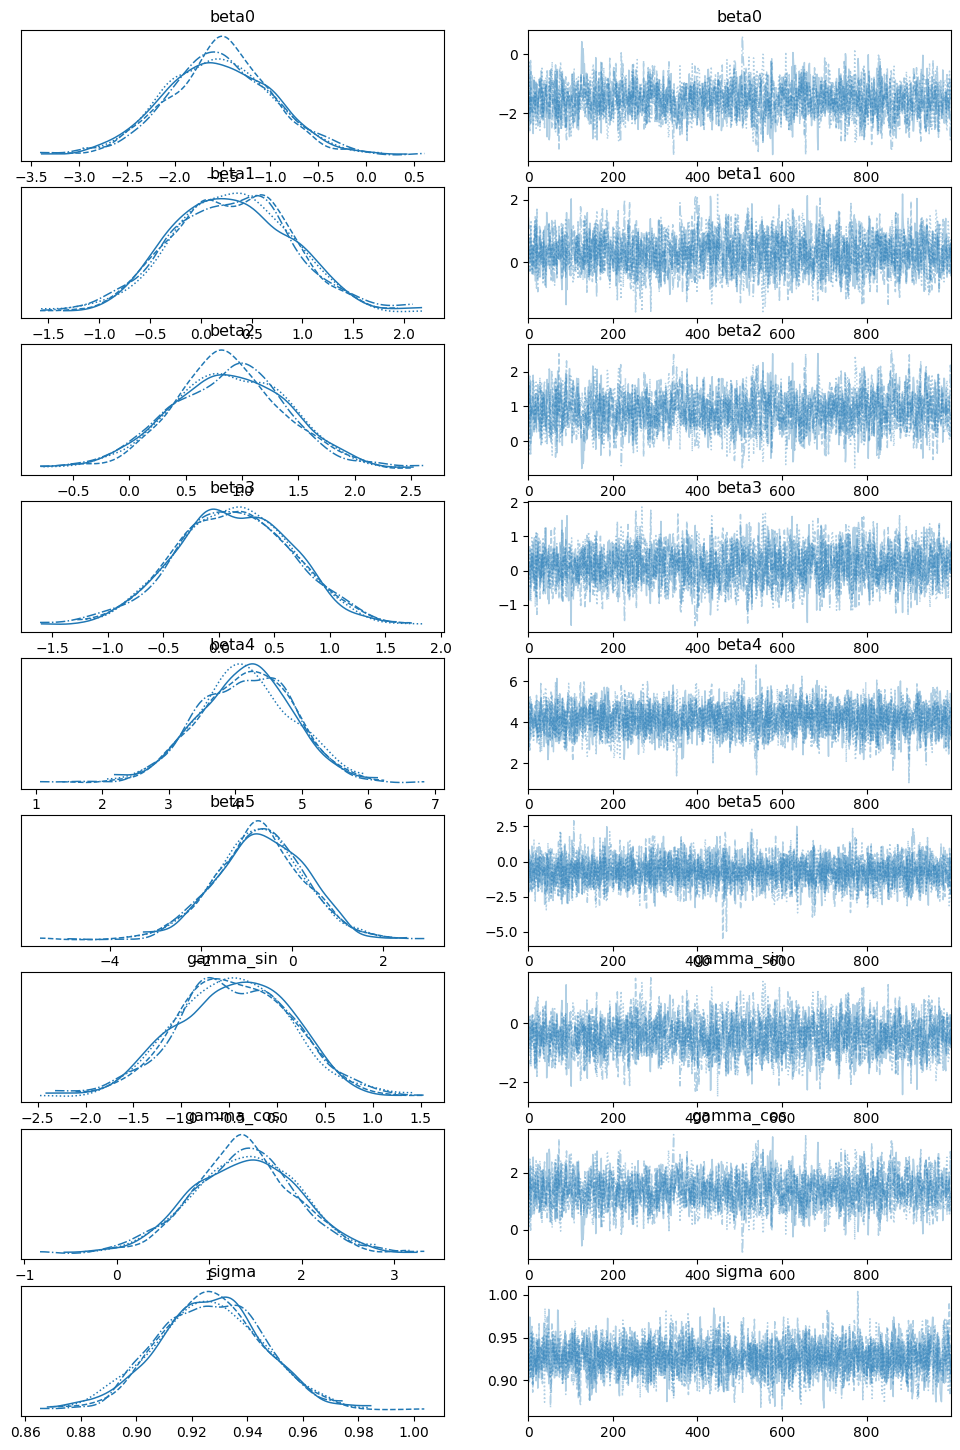

Posterior Means for Beta Coefficients: {'beta0': array(-1.53813445), 'beta1': array(0.29955385), 'beta2': array(0.88200862), 'beta3': array(0.13984424)}


In [66]:
import arviz as az
import matplotlib.pyplot as plt

# Display summary statistics of the trace
summary = az.summary(trace)
print(summary)

# Plot the trace to check convergence
az.plot_trace(trace)
plt.show()

# Extract posterior means for beta coefficients
beta_means = {var_name: trace.posterior[var_name].mean().values for var_name in ['beta0', 'beta1', 'beta2', 'beta3']}
print("Posterior Means for Beta Coefficients:", beta_means)

In [69]:
# Extract the mean of sigma from the trace and convert it to a float
sigma_samples = np.array(trace.posterior['sigma'].values.flatten(), dtype=np.float64)

# Function to update posterior samples with new data, including all parameters
def update_posterior_with_new_data(y_new, x_new, current_samples):
    beta0_samples = np.array(current_samples['beta0'], dtype=np.float64)
    beta1_samples = np.array(current_samples['beta1'], dtype=np.float64)
    beta2_samples = np.array(current_samples['beta2'], dtype=np.float64)
    beta3_samples = np.array(current_samples['beta3'], dtype=np.float64)
    beta4_samples = np.array(current_samples['beta4'], dtype=np.float64)
    beta5_samples = np.array(current_samples['beta5'], dtype=np.float64)
    gamma_sin_samples = np.array(current_samples['gamma_sin'], dtype=np.float64)
    gamma_cos_samples = np.array(current_samples['gamma_cos'], dtype=np.float64)
    sigma_samples = np.array(current_samples['sigma'], dtype=np.float64)
    
    # Compute predictions for new data using current samples
    predictions = (
        beta0_samples +
        beta1_samples * x_new +
        beta2_samples * (x_new ** 2) / 2 +
        beta3_samples * (x_new ** 3) / 6 +
        beta4_samples * (x_new ** 4) / 24 +
        beta5_samples * (x_new ** 5) / 120 +
        gamma_sin_samples * np.sin(x_new) +
        gamma_cos_samples * np.cos(x_new)
    )
    
    # Calculate likelihood weights based on new observations
    likelihood_weights = np.exp(-0.5 * ((y_new - predictions) ** 2) / sigma_samples**2)
    likelihood_weights /= np.sum(likelihood_weights)  # Normalize
    
    # Check for NaN or zero-sum issues and adjust if necessary
    if np.isnan(likelihood_weights).any() or np.sum(likelihood_weights) == 0:
        print("Warning: Adjusting likelihood weights due to NaNs or zero-sum.")
        likelihood_weights = np.nan_to_num(likelihood_weights, nan=1e-10)
        likelihood_weights /= np.sum(likelihood_weights)

    # Resample to form the updated posterior
    updated_samples = {
        'beta0': np.random.choice(beta0_samples, size=len(beta0_samples), p=likelihood_weights),
        'beta1': np.random.choice(beta1_samples, size=len(beta1_samples), p=likelihood_weights),
        'beta2': np.random.choice(beta2_samples, size=len(beta2_samples), p=likelihood_weights),
        'beta3': np.random.choice(beta3_samples, size=len(beta3_samples), p=likelihood_weights),
        'beta4': np.random.choice(beta4_samples, size=len(beta4_samples), p=likelihood_weights),
        'beta5': np.random.choice(beta5_samples, size=len(beta5_samples), p=likelihood_weights),
        'gamma_sin': np.random.choice(gamma_sin_samples, size=len(gamma_sin_samples), p=likelihood_weights),
        'gamma_cos': np.random.choice(gamma_cos_samples, size=len(gamma_cos_samples), p=likelihood_weights),
        'sigma': np.random.choice(sigma_samples, size=len(sigma_samples), p=likelihood_weights)
    }
    
    return updated_samples

# Initialize the posterior samples with values from the trace
updated_samples = {
    'beta0': np.array(trace.posterior['beta0'].values.flatten(), dtype=np.float64),
    'beta1': np.array(trace.posterior['beta1'].values.flatten(), dtype=np.float64),
    'beta2': np.array(trace.posterior['beta2'].values.flatten(), dtype=np.float64),
    'beta3': np.array(trace.posterior['beta3'].values.flatten(), dtype=np.float64),
    'beta4': np.array(trace.posterior['beta4'].values.flatten(), dtype=np.float64),
    'beta5': np.array(trace.posterior['beta5'].values.flatten(), dtype=np.float64),
    'gamma_sin': np.array(trace.posterior['gamma_sin'].values.flatten(), dtype=np.float64),
    'gamma_cos': np.array(trace.posterior['gamma_cos'].values.flatten(), dtype=np.float64),
    'sigma': sigma_samples
}

# Perform the updates with each new data point using the extracted sigma value
for new_x, new_y in zip(X_update_scaled, y_update_scaled):
    updated_samples = update_posterior_with_new_data(new_y, new_x, updated_samples)

/var/folders/n4/zjd0h9l56bb9c6pjr7j5h3nm0000gn/T/ipykernel_13147/1156719921.py:30: RuntimeWarning: invalid value encountered in divide
  likelihood_weights /= np.sum(likelihood_weights)  # Normalize


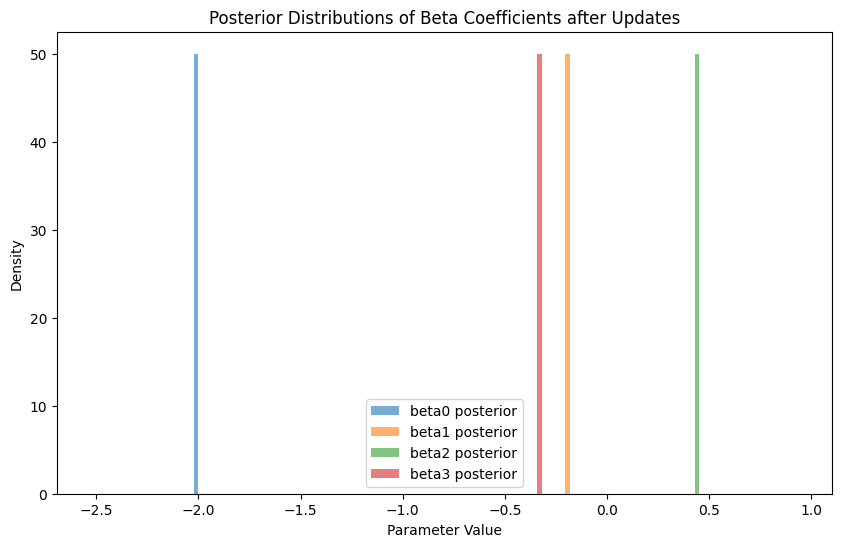

Final Means of Updated Beta Coefficients:
beta0: -2.0202755014692246
beta1: -0.20347750868523168
beta2: 0.42821711103506915
beta3: -0.34071370474583923
beta4: 3.4312734903123765
beta5: -1.8060128691065025
gamma_sin: -1.2289084412894258
gamma_cos: 1.6545413366498023
sigma: 0.9749544008251583


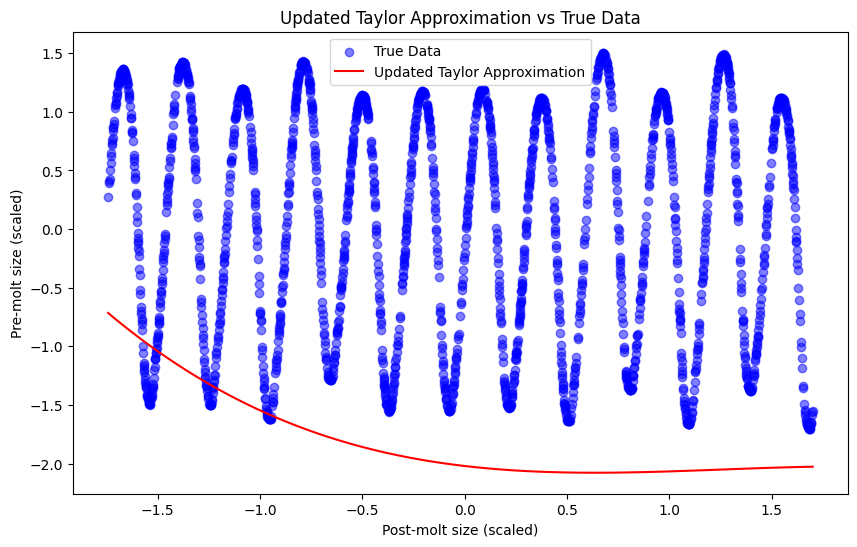

Mean Squared Error (MSE) of the Updated Taylor Approximation: 4.31590545535375
Mean Absolute Error (MAE) of the Updated Taylor Approximation: 1.817779026239111


In [70]:
import matplotlib.pyplot as plt
import arviz as az

# Visualize the updated beta distributions using density plots
plt.figure(figsize=(10, 6))
plt.title("Posterior Distributions of Beta Coefficients after Updates")
for beta in ['beta0', 'beta1', 'beta2', 'beta3']:
    plt.hist(updated_samples[beta], bins=50, alpha=0.6, density=True, label=f"{beta} posterior")
plt.legend()
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.show()

# Calculate the mean of the updated beta coefficients
final_means = {key: np.mean(values) for key, values in updated_samples.items()}
print("Final Means of Updated Beta Coefficients:")
for key, value in final_means.items():
    print(f"{key}: {value}")

# Define a function for the updated Taylor approximation using the final means
def updated_taylor_approximation(x, beta_means):
    return (
        beta_means['beta0'] +
        beta_means['beta1'] * x +
        beta_means['beta2'] * (x ** 2) / 2 +
        beta_means['beta3'] * (x ** 3) / 6
    )

# Generate predictions using the updated Taylor approximation
X_full = np.linspace(X_test_scaled.min(), X_test_scaled.max(), 100)
y_updated_approx = updated_taylor_approximation(X_full, final_means)

# Plot the updated Taylor approximation against the true data
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled, y_test_scaled, color='blue', alpha=0.5, label="True Data")
plt.plot(X_full, y_updated_approx, color='red', label="Updated Taylor Approximation")
plt.xlabel("Post-molt size (scaled)")
plt.ylabel("Pre-molt size (scaled)")
plt.title("Updated Taylor Approximation vs True Data")
plt.legend()
plt.show()

# Calculate performance metrics for the updated Taylor approximation
y_pred = updated_taylor_approximation(X_test_scaled, final_means)
mse = mean_squared_error(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
print(f"Mean Squared Error (MSE) of the Updated Taylor Approximation: {mse}")
print(f"Mean Absolute Error (MAE) of the Updated Taylor Approximation: {mae}")
